In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split, StratifiedKFold
import glob, os

In [2]:
import keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras.utils import np_utils

/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
%matplotlib inline
keras.backend.set_image_data_format('channels_last')
keras.backend.clear_session()

In [4]:
PATH_TO_CROPPED_IMAGES = '../images/cropped/'
PATH_TO_LABELS = '../annotations/cropped_color_label.csv'
CLASSES = 6
H, W, CH = 36, 64, 3

In [5]:
def get_model():
    
    x = Input((H, W, CH))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 32, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = GlobalAveragePooling2D()(model)
 
    model = Dense(CLASSES, activation = 'softmax')(model)
    
    model = Model(inputs = x, outputs = model)
    
    opt_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(opt_adam, loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [6]:
#model = get_model()
#model.summary()

In [7]:
df = pd.read_csv(PATH_TO_LABELS)
df.head(6)

,filename,label,color
0,000_pic.JPG,5,Blue
1,001_pic.JPG,3,White
2,002_pic.JPG,1,Green
3,003_pic.JPG,6,Red
4,004_pic.JPG,2,Yellow
5,005_pic.JPG,4,Gray


In [8]:
def label_to_color(label):
    dic = {1: 'Green', 2:'Yellow', 3:'White', 4:'Gray', 5:'Blue', 6:'Red'}
    if (label.dtype == np.dtype('int64')):
        return dic[label]
    else:
        return dic[np.argmax(label)+1]

In [9]:
X = []
y = []
for _, row in df.iterrows():
    img = cv.imread(os.path.join(PATH_TO_CROPPED_IMAGES, row['filename']))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (W, H))
    X.append(img)
    y.append(row['label'])

X = np.asarray(X)
y = np.asarray(y)

In [10]:
print(X.shape)

(104, 36, 64, 3)


In [11]:
# classes summary
for i in range(CLASSES):
    print(np.sum(y == (i+1)))

18
22
13
12
19
20


In [12]:
def y_to_1hot(y):
    y_1hot = np.zeros((y.shape[0], CLASSES))
    y_1hot[np.arange(y.shape[0]), y-1] = 1
    return y_1hot

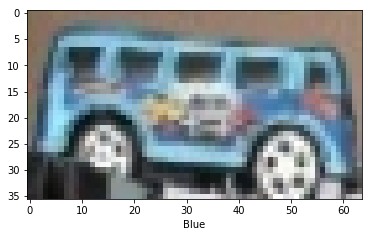

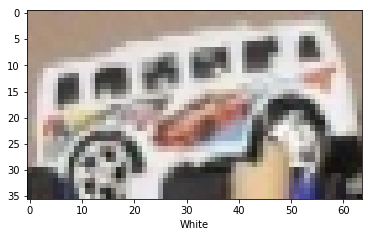

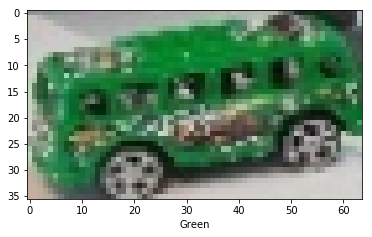

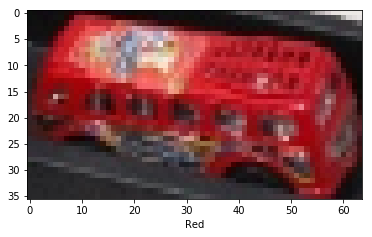

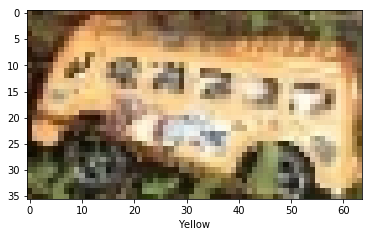

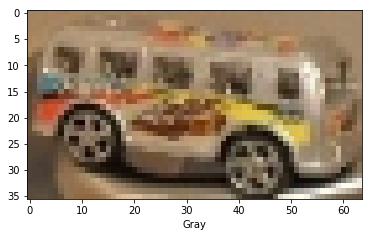

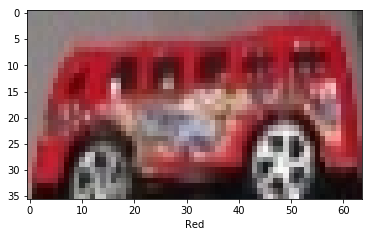

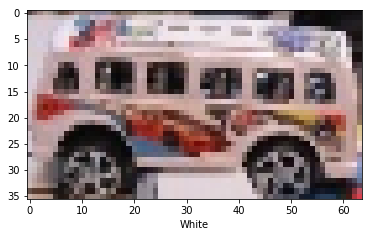

In [13]:
# view data
n = 8
for img, lab in zip(X[:n], y[:n]):
    plt.figure()
    plt.xlabel(label_to_color(lab))
    plt.imshow(img)

In [14]:
k = 6
folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
folds.get_n_splits(X, y)

6

In [15]:
# 1-fold basic example
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [16]:
batch_size = 16
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 90,
                         shear_range=0.2,
                         brightness_range=(0.8, 1.2)
                        )

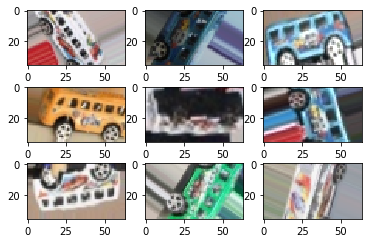

In [17]:
# Check augmentation
gen.fit(X)
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in gen.flow(X, y, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(int))
    # show the plot
    plt.show()
    break

In [18]:
def get_callbacks(fold, patience_lr):
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                       patience=patience_lr, verbose=0, epsilon=1e-4, mode='min')
    tb = keras.callbacks.TensorBoard(log_dir='./Graph/fold-{}/'.format(fold), batch_size=batch_size,
                                     write_graph=True, write_images=True, write_grads=True)
    #weights_cp = LambdaCallback(on_epoch_end=lambda epoch, logs: model.save_weights(filepath='./weights/weights.fold_{}_epoch_{:04d}_val_acc_{:.2f}.hdf5'.format(fold, epoch, logs['val_acc'])))
    
    return [reduce_lr_loss, tb]

In [19]:
j = 1
models = []
for train_idx, val_idx in folds.split(X,y):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    X_valid_cv = X[val_idx]
    y_train_cv = y[train_idx]
    y_train_cv = y_to_1hot(y_train_cv)
    y_valid_cv= y[val_idx]
    y_valid_cv = y_to_1hot(y_valid_cv)
        
    callbacks = get_callbacks(j, patience_lr=10)
    j += 1
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    history = model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=200,
                shuffle=True,
                verbose=0,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    models.append(history)
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  1
20/20 [==============================] - 0s 1ms/step
[0.37806734442710876, 0.800000011920929]

Fold  2
18/18 [==============================] - 0s 1ms/step
[0.07771354168653488, 1.0]

Fold  3
17/17 [==============================] - 0s 1ms/step
[0.25024136900901794, 0.9411764740943909]

Fold  4
17/17 [==============================] - 0s 330us/step
[1.2733170986175537, 0.6470588445663452]

Fold  5
16/16 [==============================] - 0s 244us/step
[0.6324587464332581, 0.75]

Fold  6
16/16 [==============================] - 0s 252us/step
[0.42758989334106445, 0.8125]


In [20]:
y_inf = y.copy()
y_inf = y_to_1hot(y_inf)
model.evaluate(X, y_inf)

104/104 [==============================] - 0s 386us/step


[0.38532968209340024, 0.8269230769230769]

In [21]:
y_pred = model.predict(X)

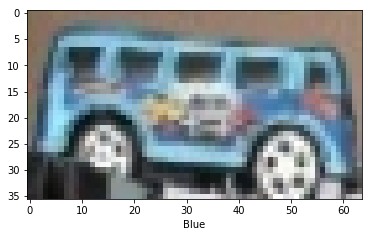

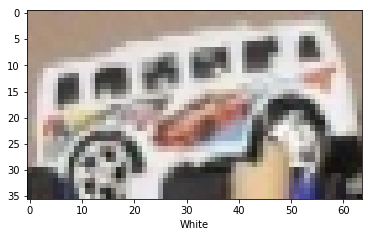

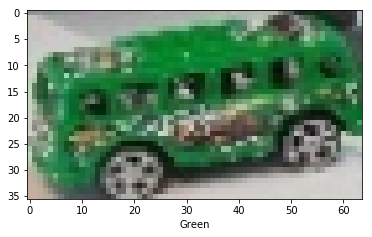

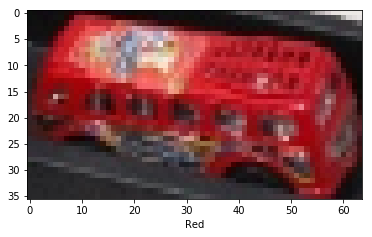

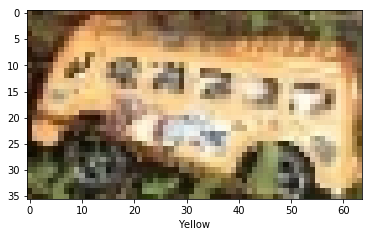

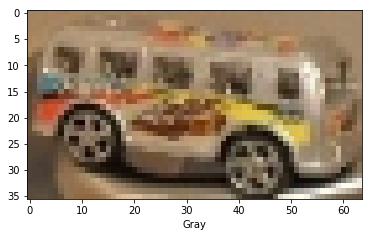

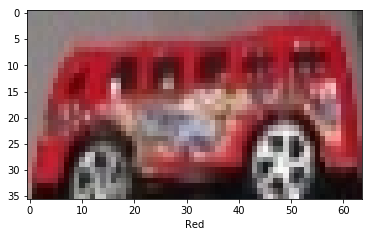

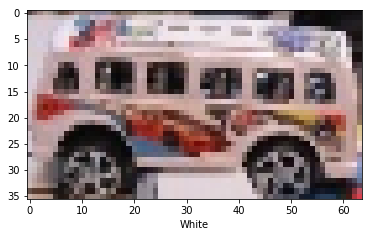

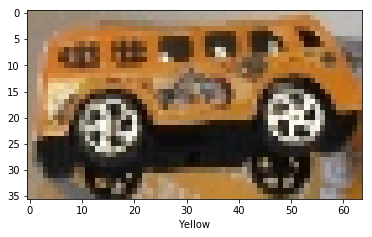

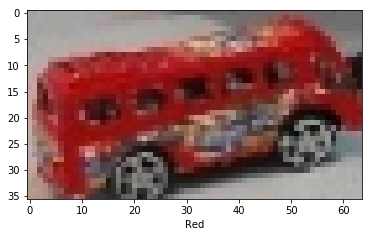

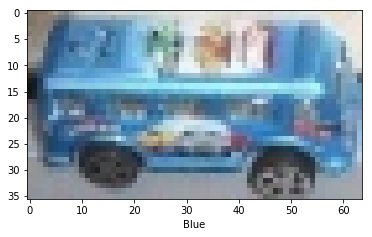

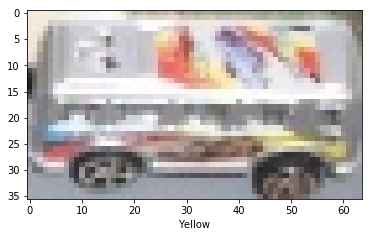

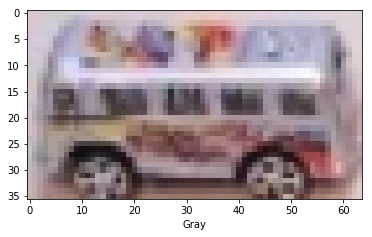

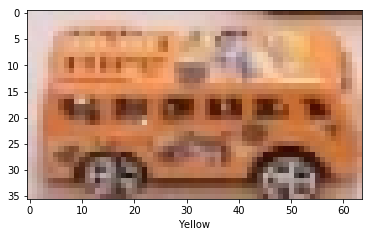

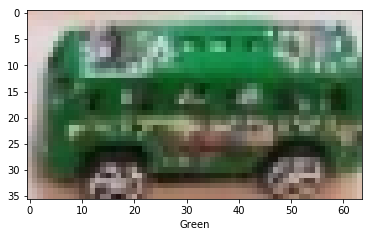

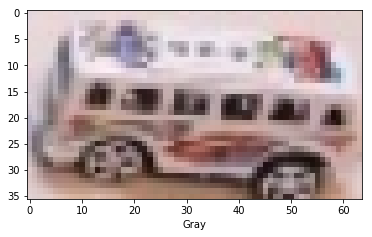

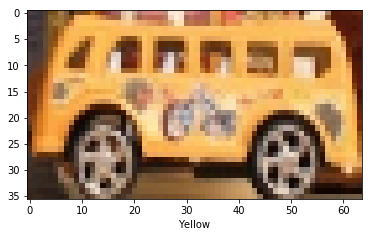

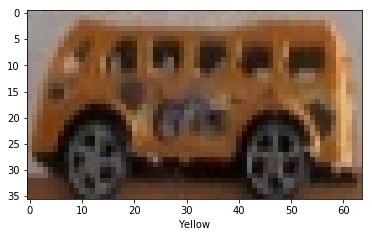

In [22]:
n = 18
for img, lab in zip(X[:n], y_pred[:n]):
    plt.figure()
    plt.xlabel(label_to_color(lab))
    plt.imshow(img)